In [71]:
#Load packages
import nltk
import re
import pandas as pd
import numpy as np
import string
from collections import defaultdict
from collections import  Counter
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, GlobalMaxPooling1D, SpatialDropout1D
import seaborn as sns
from sklearn.svm import SVC
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, f1_score, precision_recall_curve
from sklearn.model_selection import GridSearchCV, train_test_split,cross_val_score
import xgboost as xgb
from sklearn.naive_bayes import GaussianNB
from scipy.sparse import hstack
from wordcloud import WordCloud
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [72]:
dir(nltk)

['AbstractLazySequence',
 'AffixTagger',
 'AlignedSent',
 'Alignment',
 'AnnotationTask',
 'ApplicationExpression',
 'Assignment',
 'BigramAssocMeasures',
 'BigramCollocationFinder',
 'BigramTagger',
 'BinaryMaxentFeatureEncoding',
 'BlanklineTokenizer',
 'BllipParser',
 'BottomUpChartParser',
 'BottomUpLeftCornerChartParser',
 'BottomUpProbabilisticChartParser',
 'Boxer',
 'BrillTagger',
 'BrillTaggerTrainer',
 'CFG',
 'CRFTagger',
 'CfgReadingCommand',
 'ChartParser',
 'ChunkParserI',
 'ChunkScore',
 'Cistem',
 'ClassifierBasedPOSTagger',
 'ClassifierBasedTagger',
 'ClassifierI',
 'ConcordanceIndex',
 'ConditionalExponentialClassifier',
 'ConditionalFreqDist',
 'ConditionalProbDist',
 'ConditionalProbDistI',
 'ConfusionMatrix',
 'ContextIndex',
 'ContextTagger',
 'ContingencyMeasures',
 'CoreNLPDependencyParser',
 'CoreNLPParser',
 'Counter',
 'CrossValidationProbDist',
 'DRS',
 'DecisionTreeClassifier',
 'DefaultTagger',
 'DependencyEvaluator',
 'DependencyGrammar',
 'DependencyGrap

In [73]:
pd.set_option('display.max_columns',None)

In [74]:
df_train=pd.read_csv('train.csv')

# Analyze the data

In [75]:
#shape of the data
print('number of rows and columns in the dataset is {}'.format(df_train.shape))

number of rows and columns in the dataset is (7613, 5)


In [76]:
#How many of them are real and non real disasters
print("Out of {} rows \n {} are real disasters \n {} are not real disasters\n in train dataset".format(len(df_train),
                                                       len(df_train[df_train['target']==1]),
                                                       len(df_train[df_train['target']==0])))

Out of 7613 rows 
 3271 are real disasters 
 4342 are not real disasters
 in train dataset


In [77]:
#How many missing data per each column
print('Number of missing values in column-Keyword is {}'.format(df_train['keyword'].isnull().sum()))
print('Number of missing values in column-location is {}'.format(df_train['location'].isnull().sum()))
print('Number of missing values in column-text is {}'.format(df_train['text'].isnull().sum()))
print('Number of missing values in column-target is {}'.format(df_train['target'].isnull().sum()))

Number of missing values in column-Keyword is 61
Number of missing values in column-location is 2533
Number of missing values in column-text is 0
Number of missing values in column-target is 0


# Example of Disaster Tweets

In [78]:
df_train[df_train['target']== 1]['text'][10:15]

10          Three people died from the heat wave so far
11    Haha South Tampa is getting flooded hah- WAIT ...
12    #raining #flooding #Florida #TampaBay #Tampa 1...
13              #Flood in Bago Myanmar #We arrived Bago
14    Damage to school bus on 80 in multi car crash ...
Name: text, dtype: object

# Frequently Used Words in Disaster Tweets

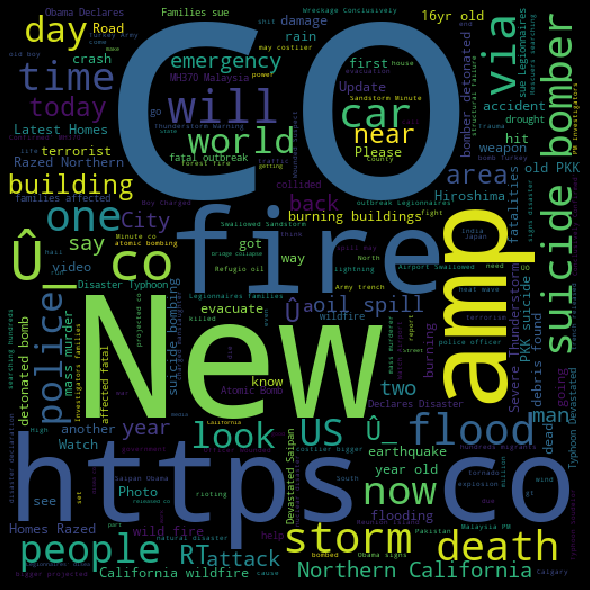

In [79]:
disaster_words = ' '.join(list(df_train[df_train['target'] == 1]['text']))
disaster_wc = WordCloud(width = 512,height = 512).generate(disaster_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(disaster_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

# Example of Non-Disaster Tweets

In [80]:
df_train[df_train['target']== 0]['text'][10:15]

25    No way...I can't eat that shit
26             Was in NYC last week!
27                Love my girlfriend
28                         Cooool :)
29                Do you like pasta?
Name: text, dtype: object

# Frequently Used Words in Non-Disaster Tweets

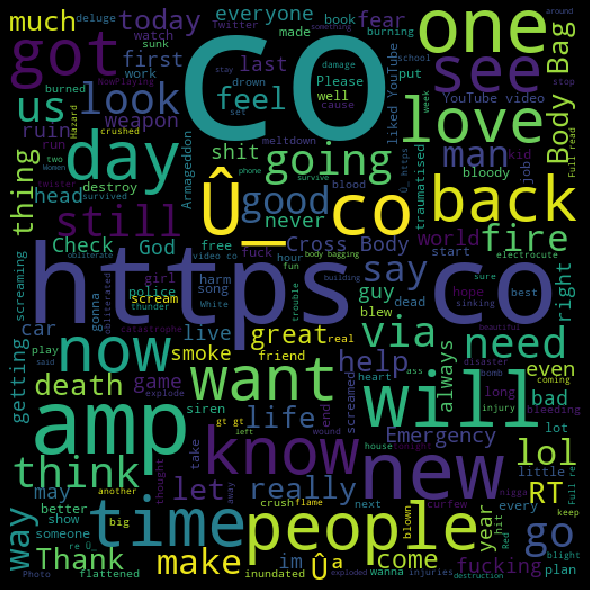

In [81]:
disaster_words = ' '.join(list(df_train[df_train['target'] == 0]['text']))
disaster_wc = WordCloud(width = 512,height = 512).generate(disaster_words)
plt.figure(figsize = (10, 8), facecolor = 'k')
plt.imshow(disaster_wc)
plt.axis('off')
plt.tight_layout(pad = 0)
plt.show()

# Exploratory Data Analysis

In [82]:
#Check distribution of class labels
x=df_train.target.value_counts()
sns.barplot(x.index,x)
plt.gca().set_ylabel('samples')

Text(0, 0.5, 'samples')

In [83]:
real_fake = [len(df_train[df_train['target']==1]),len(df_train[df_train['target']==0])]
activities = ['Real', 'Not Real']
colors = ['r', 'g']
plt.pie(real_fake, labels=activities, colors=colors, startangle=90, autopct='%.1f%%')
plt.show()

# Word Lengths for Disaster and Non-Disaster Tweets

In [84]:
df_train['text_length']=df_train['text'].apply(lambda x : len(x))

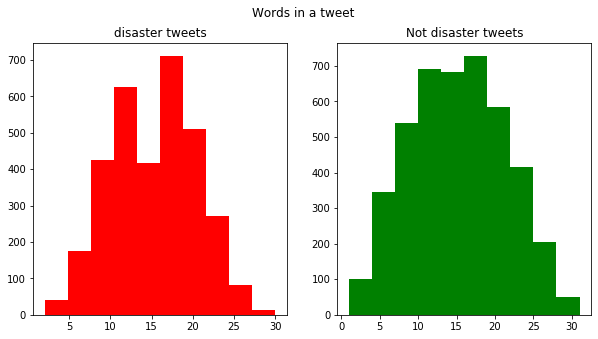

In [85]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=df_train[df_train['target']==1]['text'].str.split().map(lambda x: len(x))
ax1.hist(tweet_len,color='red')
ax1.set_title('disaster tweets')
tweet_len=df_train[df_train['target']==0]['text'].str.split().map(lambda x: len(x))
ax2.hist(tweet_len,color='green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Words in a tweet')
plt.show()

# Common Stop Words in Disaster Tweets

In [86]:
stop=set(stopwords.words('english'))

In [87]:
def create_corpus(target):
    corpus=[]
    
    for x in df_train[df_train['target']==1]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

In [88]:
corpus=create_corpus(0)

dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 

In [89]:
x,y=zip(*top)
plt.bar(x,y)

<BarContainer object of 10 artists>

# Common Words in Tweets

In [90]:
counter=Counter(corpus)
most=counter.most_common()
x=[]
y=[]
for word,count in most[:40]:
    if (word not in stop) :
        x.append(word)
        y.append(count)

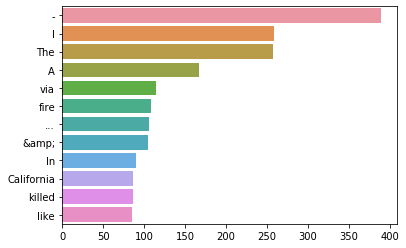

In [91]:
sns.barplot(x=y,y=x)

# Preprocessing

In [92]:
custom_stop_list = []
stopword_set = nltk.corpus.stopwords.words('english')+custom_stop_list+['url']
wn = nltk.WordNetLemmatizer()

In [93]:
#Remove urls, html, punctuation
def preProcess(iter):
        # remove extra space
        regex_ws=re.compile("\s+")
        ret=regex_ws.sub(" ",iter)
        #ret=ret.replace("&amp;","&").replace("&lt;","<").replace("&gt;",">")
        #text="".join([word for word in text if word not in string.punctuation])
        
        #Replace URL
        regexp="(https?:\/\/(?:www\.|(?!www)|(?:xmlns\.))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})"
        ret=re.sub(regexp,"url",ret)
       
        #replace @addresses
        regexp='@[A-z0-9_]+'
        ret=re.sub(regexp,"@twitterhandle",ret)
        
        #Split on punctuations
        ret1=re.split("[,_, \<>!\?\.:\n\"=*/]+",ret)
        
        #Remove Stopwords
        ret2=[word for word in ret1 if word not in stopword_set]
        ret2=" ".join(ret2)
        
        #Remove  numbers
        ret2=re.sub(r"(\s\d+)"," ",ret2)
        
        return ret2

In [94]:
df_train['body_text_nostop']=df_train['text'].apply(lambda x: preProcess(x.lower()))

In [95]:
string.punctuation
def remove_punctuation(text):
    text_nopunct="".join([char for char in text if char not in string.punctuation])
    return text_nopunct

In [96]:
df_train['body_text_nopunct']=df_train['body_text_nostop'].apply(lambda x:remove_punctuation(x))

In [97]:
df_train.head()

id keyword location                                               text  \
0   1     NaN      NaN  Our Deeds are the Reason of this #earthquake M...   
1   4     NaN      NaN             Forest fire near La Ronge Sask. Canada   
2   5     NaN      NaN  All residents asked to 'shelter in place' are ...   
3   6     NaN      NaN  13,000 people receive #wildfires evacuation or...   
4   7     NaN      NaN  Just got sent this photo from Ruby #Alaska as ...   

   target  text_length                                   body_text_nostop  \
0       1           69      deeds reason #earthquake may allah forgive us   
1       1           38              forest fire near la ronge sask canada   
2       1          133  residents asked 'shelter place' notified offic...   
3       1           65  13  people receive #wildfires evacuation order...   
4       1           88  got sent photo ruby #alaska smoke #wildfires p...   

                                   body_text_nopunct  
0       deeds reason earthquake may allah forgive us  
1              forest fire near la ronge sask canada  
2  residents asked shelter place notified officer...  
3  13  people receive wildfires evacuation orders...  
4  got sent photo ruby alaska smoke wildfires pou...

In [98]:
features_nan=[feature for feature in df_train.columns if df_train[feature].isnull().sum()>1 and df_train[feature].dtypes=='O']

for feature in features_nan:
    print("{}: {}% missing values".format(feature,np.round(df_train[feature].isnull().mean(),4)))

keyword: 0.008% missing values
location: 0.3327% missing values


In [99]:
def replace_miss_value(df_train,features_nan):
    data=df_train.copy()
    data[features_nan]=data[features_nan].fillna('missing')
    return data

df_train=replace_miss_value(df_train,features_nan)
df_train.isnull().sum()

id                   0
keyword              0
location             0
text                 0
target               0
text_length          0
body_text_nostop     0
body_text_nopunct    0
dtype: int64

In [100]:
df_train.head()

id  keyword location                                               text  \
0   1  missing  missing  Our Deeds are the Reason of this #earthquake M...   
1   4  missing  missing             Forest fire near La Ronge Sask. Canada   
2   5  missing  missing  All residents asked to 'shelter in place' are ...   
3   6  missing  missing  13,000 people receive #wildfires evacuation or...   
4   7  missing  missing  Just got sent this photo from Ruby #Alaska as ...   

   target  text_length                                   body_text_nostop  \
0       1           69      deeds reason #earthquake may allah forgive us   
1       1           38              forest fire near la ronge sask canada   
2       1          133  residents asked 'shelter place' notified offic...   
3       1           65  13  people receive #wildfires evacuation order...   
4       1           88  got sent photo ruby #alaska smoke #wildfires p...   

                                   body_text_nopunct  
0       deeds reason earthquake may allah forgive us  
1              forest fire near la ronge sask canada  
2  residents asked shelter place notified officer...  
3  13  people receive wildfires evacuation orders...  
4  got sent photo ruby alaska smoke wildfires pou...

In [101]:
#Creating Bag of words model using Tf-Idf
char_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='char',
    stop_words='english',
    ngram_range=(2, 6),
    norm='l2',
    min_df=0,
    smooth_idf=False,preprocessor=preProcess,
    max_features=30000)

In [102]:
train_text = df_train['body_text_nopunct']

In [103]:
char_vectorizer.fit(train_text)

C:\Users\aditi\Anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:520: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn("The parameter 'stop_words' will not be used"


TfidfVectorizer(analyzer='char', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=30000,
                min_df=0, ngram_range=(2, 6), norm='l2',
                preprocessor=<function preProcess at 0x000002134A11EEE8>,
                smooth_idf=False, stop_words='english', strip_accents='unicode',
                sublinear_tf=True, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [104]:
train_char_features = char_vectorizer.transform(train_text)

In [105]:
train_char_features.shape

(7613, 30000)

In [106]:
#sparse matrix
X_Tfidf_df=pd.DataFrame(train_char_features.toarray())
X_Tfidf_df.columns = char_vectorizer.get_feature_names()

In [107]:
X_Tfidf_df.shape

(7613, 30000)

In [108]:
X_Tfidf_df.head()

a   aa   ab   aba   aba    aba w   aban   aband   abc   abc   \
0  0.031186  0.0  0.0   0.0    0.0     0.0    0.0     0.0   0.0    0.0   
1  0.000000  0.0  0.0   0.0    0.0     0.0    0.0     0.0   0.0    0.0   
2  0.020045  0.0  0.0   0.0    0.0     0.0    0.0     0.0   0.0    0.0   
3  0.000000  0.0  0.0   0.0    0.0     0.0    0.0     0.0   0.0    0.0   
4  0.028415  0.0  0.0   0.0    0.0     0.0    0.0     0.0   0.0    0.0   

    abc n   abl   abla   ablaz   abo   abs   abso   absol   abst   abu   abus  \
0     0.0   0.0    0.0     0.0   0.0   0.0    0.0     0.0    0.0   0.0    0.0   
1     0.0   0.0    0.0     0.0   0.0   0.0    0.0     0.0    0.0   0.0    0.0   
2     0.0   0.0    0.0     0.0   0.0   0.0    0.0     0.0    0.0   0.0    0.0   
3     0.0   0.0    0.0     0.0   0.0   0.0    0.0     0.0    0.0   0.0    0.0   
4     0.0   0.0    0.0     0.0   0.0   0.0    0.0     0.0    0.0   0.0    0.0   

    abuse   ac   acc   acce   acci   accid   acco   accou   accu   accus  \
0     0.0  0.0   0.0    0.0    0.0     0.0    0.0     0.0    0.0     0.0   
1     0.0  0.0   0.0    0.0    0.0     0.0    0.0     0.0    0.0     0.0   
2     0.0  0.0   0.0    0.0    0.0     0.0    0.0     0.0    0.0     0.0   
3     0.0  0.0   0.0    0.0    0.0     0.0    0.0     0.0    0.0     0.0   
4     0.0  0.0   0.0    0.0    0.0     0.0    0.0     0.0    0.0     0.0   

    acr   acro   acros   act   acti   actio   activ   actu   actua   ad   add  \
0   0.0    0.0     0.0   0.0    0.0     0.0     0.0    0.0     0.0  0.0   0.0   
1   0.0    0.0     0.0   0.0    0.0     0.0     0.0    0.0     0.0  0.0   0.0   
2   0.0    0.0     0.0   0.0    0.0     0.0     0.0    0.0     0.0  0.0   0.0   
3   0.0    0.0     0.0   0.0    0.0     0.0     0.0    0.0     0.0  0.0   0.0   
4   0.0    0.0     0.0   0.0    0.0     0.0     0.0    0.0     0.0  0.0   0.0   

    adm   admi   adv   advi   advis   af   aff   affe   affec   afg   afgh  \
0   0.0    0.0   0.0    0.0     0.0  0.0   0.0    0.0     0.0   0.0    0.0   
1   0.0    0.0   0.0    0.0     0.0  0.0   0.0    0.0     0.0   0.0    0.0   
2   0.0    0.0   0.0    0.0     0.0  0.0   0.0    0.0     0.0   0.0    0.0   
3   0.0    0.0   0.0    0.0     0.0  0.0   0.0    0.0     0.0   0.0    0.0   
4   0.0    0.0   0.0    0.0     0.0  0.0   0.0    0.0     0.0   0.0    0.0   

    afgha   afr   afri   afric   aft   afte   after   ag   age   ago   ago   \
0     0.0   0.0    0.0     0.0   0.0    0.0     0.0  0.0   0.0   0.0    0.0   
1     0.0   0.0    0.0     0.0   0.0    0.0     0.0  0.0   0.0   0.0    0.0   
2     0.0   0.0    0.0     0.0   0.0    0.0     0.0  0.0   0.0   0.0    0.0   
3     0.0   0.0    0.0     0.0   0.0    0.0     0.0  0.0   0.0   0.0    0.0   
4     0.0   0.0    0.0     0.0   0.0    0.0     0.0  0.0   0.0   0.0    0.0   

    agr   agre   agree   ah   ahe   ahea   ahead   ai   ain   aint   aint   \
0   0.0    0.0     0.0  0.0   0.0    0.0     0.0  0.0   0.0    0.0     0.0   
1   0.0    0.0     0.0  0.0   0.0    0.0     0.0  0.0   0.0    0.0     0.0   
2   0.0    0.0     0.0  0.0   0.0    0.0     0.0  0.0   0.0    0.0     0.0   
3   0.0    0.0     0.0  0.0   0.0    0.0     0.0  0.0   0.0    0.0     0.0   
4   0.0    0.0     0.0  0.0   0.0    0.0     0.0  0.0   0.0    0.0     0.0   

    air   air    air a   airc   aircr   airl   airli   airp   airpl   airpo  \
0   0.0    0.0     0.0    0.0     0.0    0.0     0.0    0.0     0.0     0.0   
1   0.0    0.0     0.0    0.0     0.0    0.0     0.0    0.0     0.0     0.0   
2   0.0    0.0     0.0    0.0     0.0    0.0     0.0    0.0     0.0     0.0   
3   0.0    0.0     0.0    0.0     0.0    0.0     0.0    0.0     0.0     0.0   
4   0.0    0.0     0.0    0.0     0.0    0.0     0.0    0.0     0.0     0.0   

    ak        al       ala   alab   alaba   alar   alarm   alb   albu   album  \
0  0.0  0.063748  0.000000    0.0     0.0    0.0     0.0   0.0    0.0     0.0   
1  0.0  0.000000  0.000000    0.0     0.0    0.0     0.0   0.0    0.0     0.0   
2  

In [109]:
X=X_Tfidf_df
y=df_train['target']

In [110]:
X.shape

(7613, 30000)

In [111]:
y.shape

(7613,)

In [112]:
df_train=pd.DataFrame(X,y)

# K Nearest Neighbours

In [113]:
x_train, x_test, y_train, y_test = train_test_split(X,y,random_state =5)
knnclassifier = KNeighborsClassifier(n_neighbors=5)
knnclassifier.fit(x_train,y_train)
y_pred_knn = knnclassifier.predict(x_test)
accuracy_knn=metrics.accuracy_score(y_test,y_pred_knn)

In [114]:
f1score_knn=metrics.f1_score(y_test,y_pred_knn)

In [115]:
print("F1 score :", f1score_knn)
print("Accuracy :", accuracy_knn)

F1 score : 0.692871419053964
Accuracy : 0.7578781512605042


# XGBoost

In [116]:
x_train, x_test, y_train, y_test = train_test_split(X,y,random_state =5)
xgb_model = xgb.XGBClassifier()
xgb_model.fit(x_train,y_train)
y_pred = xgb_model.predict(x_test)
metrics.f1_score(y_test, y_pred)

0.7071751777634131

In [117]:
# Cross validation scores
f1_scores = model_selection.cross_val_score(xgb_model, X, y, cv=skfold, scoring='f1')
print("F1-score = ",f1_scores," Mean F1 score = ",np.mean(f1_scores))

F1-score =  [0.59989345 0.54730713 0.63653484]  Mean F1 score =  0.5945784731248396


# Naive Bayes

In [118]:
naivebayes = GaussianNB()
x_train, x_test, y_train, y_test = train_test_split(X,y,random_state =5)
naivebayes.fit(x_train,y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

In [119]:
predicted_nb = naivebayes.predict(x_test)

In [120]:
accuracy_nb=metrics.accuracy_score(y_test,predicted_nb)
f1score_nb=metrics.f1_score(y_test,predicted_nb)

In [121]:
print("F1 score :", f1score_nb)
print("Accuracy :", accuracy_nb)

F1 score : 0.6671270718232043
Accuracy : 0.7468487394957983


# SVC

In [122]:
x_train, x_test, y_train, y_test = train_test_split(X,y,random_state =5)
SVM = SVC(C=1.0, kernel='linear',degree=3, gamma='auto', max_iter=100)
SVM.fit(x_train,y_train)

C:\Users\aditi\Anaconda3\lib\site-packages\sklearn\svm\_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=100).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
    max_iter=100, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [123]:
predictions_SVM = SVM.predict(x_test)

In [124]:
print("F1 Score            ",metrics.f1_score(predictions_SVM, y_test))
print("SVM Accuracy Score  ",metrics.accuracy_score(predictions_SVM, y_test))

F1 Score             0.5748987854251012
SVM Accuracy Score   0.6139705882352942


# Logistic Regression

In [125]:
skfold = StratifiedKFold(n_splits=3, random_state=100)
model_skfold = LogisticRegression()
results_skfold = model_selection.cross_val_score(model_skfold, X, y, cv=skfold,scoring='f1')
print("F1 score: %.2f%%" % (results_skfold.mean()*100.0))

C:\Users\aditi\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


F1 score: 61.64%


In [126]:
x_train, x_test, y_train, y_test = train_test_split(X,y,random_state =5)
model = LogisticRegression(solver='liblinear', C=10.0, random_state=0)
model.fit(x_train,y_train)
y_pred = model.predict(x_test)
f1score_lr=metrics.f1_score(y_test,y_pred)
print("F1 score", f1score_lr)

F1 score 0.7415009621552278


In [127]:
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(model.score(x_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.79


In [132]:
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[923 160]
 [243 578]]


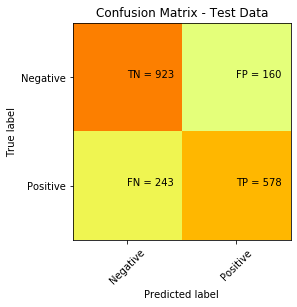

In [134]:
#923+578 tweets classified correctly
plt.clf()
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Negative','Positive']
plt.title('Confusion Matrix - Test Data')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames, rotation=45)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

In [128]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.85      0.82      1083
           1       0.78      0.70      0.74       821

    accuracy                           0.79      1904
   macro avg       0.79      0.78      0.78      1904
weighted avg       0.79      0.79      0.79      1904



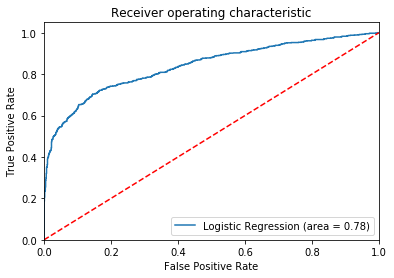

In [129]:
logit_roc_auc = roc_auc_score(y_test, model.predict(x_test))
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(x_test)[:,1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.savefig('Log_ROC')
plt.show()